### Fit a detector
- copy boiler plate code. This shouldnt take too long

In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
### Set CUDA device
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '6'

In [28]:
from typing import List, Dict, Union, Callable, Tuple
import numpy as np
import torch
from torch import Tensor, nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import sys
from omegaconf import OmegaConf
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Dict
from torchvision.transforms import GaussianBlur
from torchmetrics.functional.classification import dice
from tqdm.auto import tqdm
from torchmetrics.classification import BinaryPrecisionRecallCurve
from sklearn.metrics import auc
import builtins
from copy import deepcopy


## Augmentations
from batchgenerators.transforms.noise_transforms import augment_gaussian_blur

sys.path.append('../')
from data_utils import get_train_loader, get_eval_data
from model.unet import get_unet
from utils import  epoch_average, UMapGenerator
from model.mahalanobis_adatper import (
    PoolingMahalanobisDetector,
    get_pooling_mahalanobis_detector, 
    get_batchnorm_mahalanobis_detector
)
from model.wrapper import PoolingMahalanobisWrapper, BatchNormMahalanobisWrapper


from matplotlib.colors import ListedColormap, Normalize

def format_e(n):
    a = '%e' % n
    return a.split('e')[0].rstrip('0').rstrip('.') + 'e' + a.split('e')[1]


# Create a custom colormap - transparent for class 0, and different colors for other classes
seg_colors = ['none', 'yellow', 'green', 'blue']  # 'none' for transparent
err_colors = ['none', 'red']
seg_cmap = ListedColormap(seg_colors)
err_cmap = ListedColormap(err_colors)

# Ensure the colormap is normalized to the number of classes
seg_norm = Normalize(vmin=0, vmax=len(seg_colors)-1)
err_norm = Normalize(vmin=0, vmax=len(err_colors)-1)



In [4]:
### Load basic config
cfg = OmegaConf.load('../configs/basic_config_venusberg.yaml')
OmegaConf.update(cfg, 'run.iteration', 0)

In [19]:
### Set dataset, either brain or heart
DATA_KEY = 'heart'
OmegaConf.update(cfg, 'run.data_key', DATA_KEY)


### get model
# available models:
#     - default-8
#     - default-16
#     - monai-8-4-4
#     - monai-16-4-4
#     - monai-16-4-8
#     - monai-32-4-4
#     - monai-64-4-4
#     - swinunetr


unet_name = 'default-8'
postfix = '_all'
args = unet_name.split('-')
cfg.unet[DATA_KEY].pre = unet_name + postfix
cfg.unet[DATA_KEY].arch = args[0]
cfg.unet[DATA_KEY].n_filters_init = int(args[1])

if args[0] == 'monai':
    cfg.unet[DATA_KEY].depth = int(args[2])
    cfg.unet[DATA_KEY].num_res_units = int(args[3])

unet, state_dict = get_unet(
    cfg,
    update_cfg_with_swivels=False,
    return_state_dict=True)
unet.load_state_dict(state_dict)
_ = unet.cuda().eval()

In [6]:
# Set debug mode for only a small fraction of the datasets. Speeds up this cell by alot
cfg.debug = False

# update config with default values
OmegaConf.update(
    cfg, 
    'eval',
    OmegaConf.load('../configs/eval/unet_config.yaml')
)

# Wether and how you want to subset in case of Brain data. WARNING:
# After subsetting the eval below will not work with surface
# Dice anymore, because volumes are fragmented. 
APPLY_SUBSETTING = True
OmegaConf.update(cfg, 'eval.data.subset.apply', APPLY_SUBSETTING)
subset_params = {
    'n_cases': 256,  # selects at most so many cases
    'fraction': 0.1, # selects from the 10% worst cases w.r.t to a model
}
OmegaConf.update(
    cfg, 
    'eval.data.subset.params', 
    OmegaConf.create(subset_params)
)

if cfg.eval.data.subset.apply:
    subset_dict = OmegaConf.to_container(
        cfg.eval.data.subset.params, 
        resolve=True, 
        throw_on_missing=True
    )
    subset_dict['unet'] = unet
else:
    subset_dict = None

### select the datasets within the domain
# get training data
cfg.eval.data.training = True
# get validation data
cfg.eval.data.validation = True
# get testing data
# Options for Brain are any subset of [1, 2, 3, 4, 5] or 'all' 
# Options for Heart are any subset of ['A', 'B', 'C', 'D'] or 'all'
cfg.eval.data.testing = 'all' #['A'] #
cfg.data.heart.mnm.selection = 'non_empty_target' # 'all_cases' #'non_empty_target'

data = get_eval_data(
    train_set=cfg.eval.data.training,
    val_set=cfg.eval.data.validation,
    test_sets=cfg.eval.data.testing,    
    cfg=cfg,
    subset_dict=subset_dict
)

dataloader = DataLoader(
    data['train'], 
    batch_size=32, 
    shuffle=False, 
    drop_last=False
)

print(f'\nAvailable datasets are: {list(data.keys())}')

loading dataset
loading all case properties
loading dataset
loading all case properties
loading dataset
loading all case properties
loading dataset
loading all case properties
loading dataset
loading all case properties
loading dataset
loading all case properties

Available datasets are: ['train', 'val', 'A', 'B', 'C', 'D']


In [7]:
cfg.run.transform_key = 'all_transforms'
train_loader, valid_loader = get_train_loader(cfg=cfg, training='unet')

loading dataset
loading all case properties
loading dataset
loading all case properties


In [202]:
class ScorePredictionAdapter(nn.Module):
    def __init__(
        self,
        swivel: str,
        predictor: nn.Module,
        train_lr: float = 1e-3,
        inference_lr: float = 1e-3,
        device: str = 'cuda:0'
    ):
        super().__init__()
        self.swivel = swivel
        self.predictor = predictor
        self.train_lr = train_lr
        self.inference_lr = inference_lr
        self.device = device
        self.active = True

        self.to(device)
        self.score_collection = []


    @torch.no_grad()
    def _collect(
        self, 
        x: Tensor
    ) -> None:
        # reduces dimensionality as per self._pool, moves to cpu and stores
        x = self.predictor(x.detach()).cpu()
        self.score_collection.append(x)


    def on(self):
        self.active = True


    def off(self):
        self.active = False


    def forward(
        self,
        x: Tensor
    ) -> Tensor:
        
        if self.active:
            # if self.training:
            self.score = self.predictor(x)
            # else:
            #     raise NotImplementedError('Inference not implemented yet')
        else:
            pass
        return x
    

class ScorePredictor(nn.Module):
    def __init__(
        self, 
        input_size: list, 
        hidden_dim: int = 128, 
        output_dim: int = 1, 
        dropout_prob=0.3
    ):
        super(ScorePredictor, self).__init__()
        
        # 1x1 Conv Layer to reduce the number of input channels by a factor of 8
        self.conv1x1 = nn.Conv2d(
            in_channels=input_size[1], 
            out_channels=input_size[1] // 8, 
            kernel_size=1
        )
        
        # Activation, Norm, Dropout
        self.activation1 = nn.LeakyReLU()  # You can also use other activations like Swish or LeakyReLU
        self.norm1 = nn.BatchNorm2d(input_size[1] // 8)
        self.dropout1 = nn.Dropout(dropout_prob)
        
        # Compute flattened size after convolution for the linear layers
        conv_output_size = input_size[1] * input_size[2]*input_size[3] // 8
        
        # Fully connected layer to reduce the output of the conv to hidden_dim
        self.fc1 = nn.Linear(conv_output_size, hidden_dim)
        self.activation2 = nn.LeakyReLU()
        self.norm2 = nn.LayerNorm(hidden_dim)
        
        # Final fully connected layer to output_dim
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Pass through 1x1 convolution, activation, normalization, and dropout
        x = self.conv1x1(x)
        x = self.activation1(x)
        x = self.norm1(x)
        x = self.dropout1(x)
        
        # Flatten the output from the conv layer
        x = torch.flatten(x, start_dim=1)
        
        # Fully connected layer to hidden_dim
        x = self.fc1(x)
        x = self.activation2(x)
        x = self.norm2(x)
        
        # Final output layer
        output = self.fc2(x)
        return torch.sigmoid(output)
    


class ScorePredictionWrapper(nn.Module):
    def __init__(
        self,
        model: nn.Module,
        adapters: nn.ModuleList,
        loss_fn: nn.Module = nn.MSELoss(reduction='none'),
        copy: bool = True,
    ):
        super().__init__()
        self.model           = deepcopy(model) if copy else model
        self.adapters        = adapters
        self.adapter_handles = {}
        self.loss_fn         = loss_fn
        self.model.eval()

        self.hook_adapters()


    def hook_adapters(
        self,
    ) -> None:
        for adapter in self.adapters:
            swivel = adapter.swivel
            layer  = self.model.get_submodule(swivel)
            hook   = self._get_hook(adapter)
            self.adapter_handles[
                swivel
            ] = layer.register_forward_pre_hook(hook)


    def _get_hook(
        self,
        adapter: nn.Module
    ) -> Callable:
        def hook_fn(
            module: nn.Module, 
            x: Tuple[Tensor]
        ) -> Tensor:
            # x, *_ = x # tuple, alternatively use x_in = x[0]
            # x = adapter(x)
            return adapter(x[0])
        
        return hook_fn
    

    def set_transform(self, transform: bool):
        self.transform = transform
        for adapter in self.adapters:
            adapter.transform = transform


    def set_lr(self, lr: float):
        for adapter in self.adapters:
            adapter.lr = lr


    def turn_off_all_adapters(self):
        for adapter in self.adapters:
            adapter.off()

    
    def freeze_model(self):
        self.model.eval()
        for param in self.model.parameters():
            param.requires_grad = False


    def forward(
        self,
        x: Tensor,
        target: Tensor
    ) -> Tensor:
        
        # if self.training:
            # for adapter in self.adapters:
            #     adapter.train()
            # self.model.eval()

            # print(f'adapter mode: {self.adapters[0].training}')
            # print(f'model mode: {self.model.training}')

        logits = self.model(x).detach()
        

        dsc_per_adapter_and_class = torch.stack([
            adapter.score for adapter in self.adapters
        ], dim=1)

        return logits, dsc_per_adapter_and_class

        


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)



def find_shapes_for_swivels(
    model: nn.Module, 
    swivels: List[str],
    input_shape: Tuple[int, int, int, int] = (1, 1, 256, 256)
):
    # Create a dictionary to store the output shapes
    model = deepcopy(model).cuda()
    output_shapes = {}

    # Get hook function to capture and print output shapes for swivel
    def get_hook_fn(name):
        def hook_fn(module, input, output):
            output_shapes[name] = list(output.shape)
        return hook_fn

    # Attach hooks to all layers
    hooks = []
    for layer_id in swivels:
        layer   = model.get_submodule(layer_id)
        hook_fn = get_hook_fn(layer_id)
        hook    = layer.register_forward_hook(hook_fn)
        hooks.append(hook)

    # Run a sample input through the model
    x = torch.randn(input_shape).cuda()  # Batch size 1, 3 channels, 32x32 image
    _ = model(x)

    # remove hooks and model
    for hook in hooks:
        hook.remove()

    del model

    return output_shapes

In [203]:
# get attachment points
swivels = [layer[0] for layer in unet.named_modules() if 'bn' in layer[0]]
# get shapes for swivels
output_shapes = find_shapes_for_swivels(unet, swivels)
# init detectors with corresponding predictors
score_detectors = [
    ScorePredictionAdapter(
        swivel=swivel,
        predictor=ScorePredictor(
            input_size=output_shapes[swivel],
            output_dim=4
        )
    ) for swivel in swivels
]
# wrap the model with the detectors
wrapper = ScorePredictionWrapper(
    model=unet,
    adapters=nn.ModuleList(score_detectors)
)

wrapper.freeze_model()

In [204]:
loss_fn = nn.MSELoss(reduction='none')
optimizer = torch.optim.Adam(wrapper.parameters(), lr=1e-4)

metrics = []

for i in range(1000):
    optimizer.zero_grad()

    batch = next(train_loader)
    input = batch['data'].cuda()
    target = batch['target'].long().cuda()
    target[target == -1] = 0
    logits, dsc_per_adapter_and_class = wrapper(input, target)
    preds = torch.argmax(logits, dim=1, keepdim=True)
    DSCs = torch.stack([
            dice(
                s.flatten(), 
                t.flatten(),
                num_classes=4,
                zero_division=1,
                average='none'
            ) for s,t in zip(preds, target)
        ]).unsqueeze(1).repeat(1, dsc_per_adapter_and_class.shape[1], 1)
    
    DSCs.nan_to_num_(0)
    loss = loss_fn(dsc_per_adapter_and_class, DSCs).sum(2)
    loss = loss.sum(1).mean()
    loss.backward()
    optimizer.step()

    metrics.append(
        {
            'target': DSCs[:, 0].mean(1).cpu().detach(),
            'pred': dsc_per_adapter_and_class.mean(2).cpu().detach()
        }
    )
    if i%10 == 0:
        print(f'Iteration: {i}')
        print(loss.item())



Iteration: 0
38.19153594970703
Iteration: 10
12.883596420288086
Iteration: 20
7.326140880584717
Iteration: 30
11.174389839172363
Iteration: 40
12.849462509155273
Iteration: 50
9.595854759216309
Iteration: 60
9.444375991821289
Iteration: 70
4.690803527832031
Iteration: 80
5.5972580909729
Iteration: 90
8.660832405090332
Iteration: 100
11.765259742736816
Iteration: 110
7.848745346069336
Iteration: 120
4.340662002563477
Iteration: 130
10.905261993408203
Iteration: 140
8.84212875366211
Iteration: 150
6.553675651550293
Iteration: 160
8.194215774536133
Iteration: 170
5.287527561187744
Iteration: 180
6.779853820800781
Iteration: 190
7.331631660461426
Iteration: 200
6.111614227294922
Iteration: 210
6.613923072814941
Iteration: 220
12.470138549804688
Iteration: 230
8.141022682189941
Iteration: 240
7.586686134338379
Iteration: 250
5.440333366394043
Iteration: 260
6.510285377502441
Iteration: 270
4.861754894256592
Iteration: 280
10.744955062866211
Iteration: 290
7.413752555847168
Iteration: 300
7.

In [206]:
for name, module in wrapper.named_modules():
    if 'bn' in name:
        module.eval()

In [207]:

val_metrics = []
wrapper.train()
for name, module in wrapper.named_modules():
    if 'bn' in name:
        module.eval()


for i in range(10):

    batch = next(valid_loader)
    input = batch['data'].cuda()
    target = batch['target'].long().cuda()
    target[target == -1] = 0
    logits, dsc_per_adapter_and_class = wrapper(input, target)
    preds = torch.argmax(logits, dim=1, keepdim=True)
    DSCs = torch.stack([
            dice(
                s.flatten(), 
                t.flatten(),
                num_classes=4,
                zero_division=1,
                average='none'
            ) for s,t in zip(preds, target)
        ]).unsqueeze(1).repeat(1, dsc_per_adapter_and_class.shape[1], 1)
    
    DSCs.nan_to_num_(0)

    val_metrics.append(
        {
            'target': DSCs[:, 0].mean(1).cpu().detach(),
            'pred': dsc_per_adapter_and_class.mean(2).cpu().detach()
        }
    )


In [212]:
test_loader = DataLoader(
    data['A'], 
    batch_size=32, 
    shuffle=False, 
    drop_last=True
)
test_metrics = []
for i, batch in enumerate(test_loader):

    # batch = next(valid_loader)
    input = batch['input'].cuda()
    target = batch['target'].long().cuda()
    target[target == -1] = 0
    logits, dsc_per_adapter_and_class = wrapper(input, target)
    preds = torch.argmax(logits, dim=1, keepdim=True)
    DSCs = torch.stack([
            dice(
                s.flatten(), 
                t.flatten(),
                num_classes=4,
                zero_division=1,
                average='none'
            ) for s,t in zip(preds, target)
        ]).unsqueeze(1).repeat(1, dsc_per_adapter_and_class.shape[1], 1)
    
    DSCs.nan_to_num_(0)

    test_metrics.append(
        {
            'target': DSCs[:, 0].mean(1).cpu().detach(),
            'pred': dsc_per_adapter_and_class.mean(2).cpu().detach()
        }
    )

    if i==10:
        break

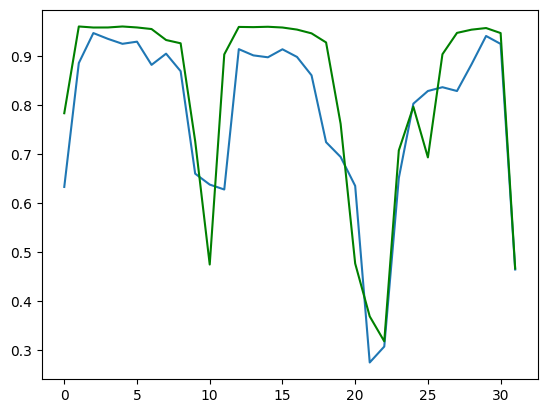

40
tensor([0.6784, 2.0132, 1.2343, 0.7461, 1.2183, 1.7112, 1.4608, 1.4068, 1.0456,
        1.8697, 0.8104, 1.4896, 0.8994, 1.0385, 0.5218, 1.0472, 0.5141, 1.1724,
        0.8764, 1.1988, 0.8866, 0.6697, 0.4145, 0.5049, 0.4218, 0.4356, 0.5185,
        0.5432, 0.4716, 0.5110, 0.4448, 0.3132, 0.3174, 0.4655, 0.3668, 0.4221,
        0.3895, 0.3085, 0.3785, 0.5483, 0.2960, 0.3742, 0.4465, 0.4085, 0.4274])


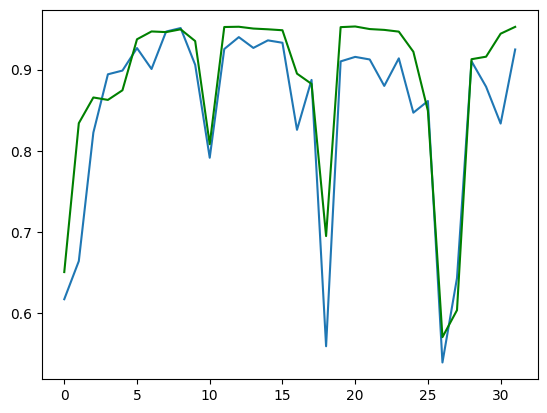

38
tensor([0.6569, 1.3027, 0.4201, 0.4972, 0.3296, 1.1083, 0.3757, 0.4422, 0.4551,
        0.6840, 0.5708, 0.5885, 0.2792, 0.3884, 0.3169, 0.2997, 0.2930, 0.3594,
        0.3472, 0.3726, 0.2023, 0.2952, 0.3745, 0.2488, 0.2074, 0.2326, 0.2333,
        0.2383, 0.2478, 0.3343, 0.6985, 0.2266, 0.2362, 0.2641, 0.1567, 0.2198,
        0.2115, 0.1120, 0.0952, 0.5764, 0.1306, 0.2689, 1.0626, 0.1691, 0.1446])


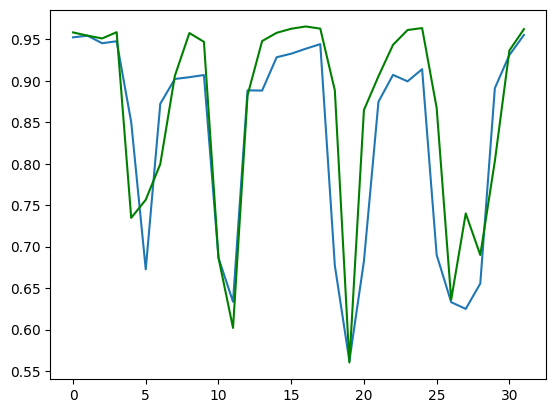

33
tensor([0.5602, 0.7352, 0.4605, 0.6832, 0.3878, 1.1355, 0.5045, 0.4116, 0.6948,
        0.3887, 0.6939, 0.3610, 0.5992, 0.4038, 0.3265, 0.5479, 0.2755, 0.6036,
        0.4475, 0.4484, 0.2702, 0.3664, 0.3040, 0.3223, 0.2477, 0.3346, 0.3105,
        0.2901, 0.2851, 0.3220, 0.2732, 0.2682, 0.3637, 0.1776, 0.2197, 0.2223,
        0.2471, 0.1843, 0.2002, 0.2414, 0.2009, 0.2862, 0.7004, 0.2597, 0.2651])


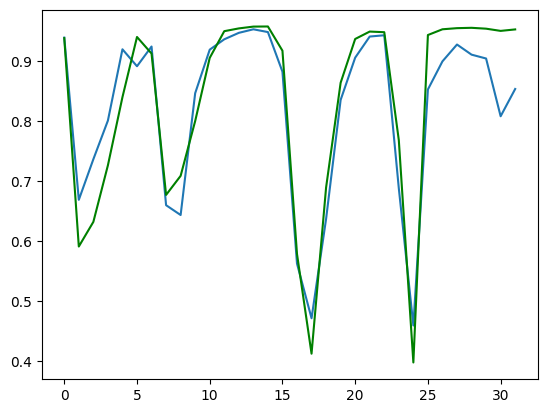

37
tensor([0.7435, 0.8129, 0.6489, 0.6420, 0.6113, 2.2431, 0.8641, 0.5580, 0.4760,
        0.4974, 0.8722, 0.5806, 0.6590, 0.7135, 0.4045, 0.6249, 0.4193, 0.7786,
        0.6693, 0.6444, 0.6358, 0.3927, 0.2589, 0.4245, 0.2227, 0.3375, 0.2109,
        0.1719, 0.1828, 0.1761, 0.1480, 0.1525, 0.2672, 0.2105, 0.1305, 0.2229,
        0.1605, 0.1048, 0.2342, 0.2422, 0.1764, 0.2077, 0.6216, 0.2496, 0.1903])


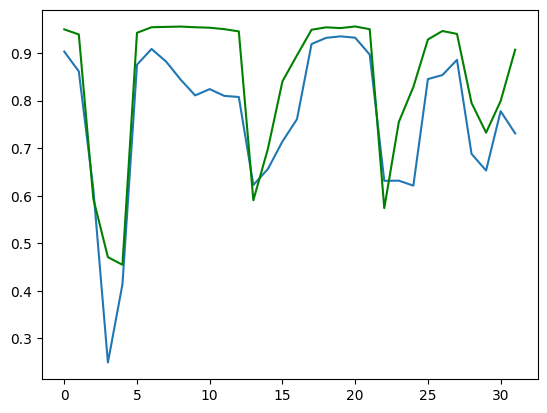

31
tensor([1.0671, 1.5547, 1.0292, 1.2985, 1.2679, 1.1793, 1.3444, 1.2061, 0.9865,
        1.2354, 1.2148, 1.0442, 1.1062, 1.0418, 0.8847, 1.2693, 0.9601, 1.0702,
        0.9824, 0.8261, 0.9755, 0.9282, 0.4415, 0.4203, 0.3980, 0.4638, 0.5085,
        0.5161, 0.3873, 0.4829, 0.4280, 0.3309, 0.4048, 0.4760, 0.4413, 0.3770,
        0.4304, 0.3636, 0.4579, 0.3685, 0.5962, 0.5255, 0.6188, 0.3371, 0.4210])


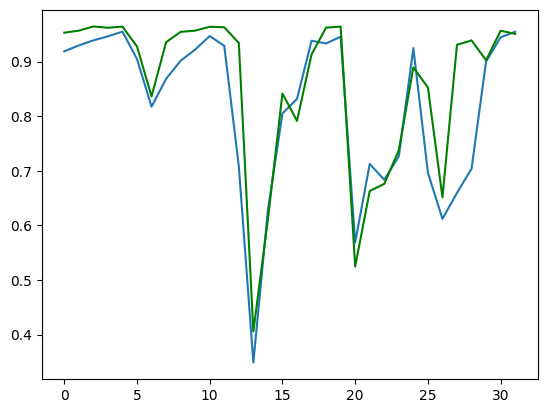

33
tensor([1.1746, 1.1093, 0.7143, 1.0275, 0.7181, 3.5456, 0.6808, 0.9304, 0.7846,
        0.8875, 0.9839, 0.8280, 0.9549, 0.7331, 0.6252, 0.5990, 0.8199, 0.7391,
        0.5074, 0.4701, 0.3835, 0.4069, 0.3402, 0.3172, 0.2847, 0.2675, 0.3562,
        0.2546, 0.2716, 0.2833, 0.3137, 0.3066, 0.3356, 0.2334, 0.3408, 0.3259,
        0.2688, 0.2782, 0.2547, 0.3378, 0.2459, 0.2647, 0.5116, 0.3145, 0.3302])


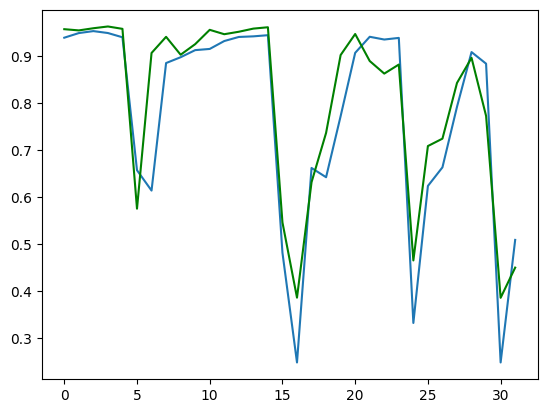

33
tensor([0.9326, 1.8598, 1.7601, 1.6014, 1.3907, 2.8450, 1.9907, 1.4383, 1.3618,
        1.6129, 1.8224, 1.2233, 1.8605, 1.3162, 1.0232, 1.1125, 1.3021, 1.4057,
        0.9400, 1.3495, 1.1617, 0.9523, 0.4869, 0.4415, 0.3175, 0.4670, 0.4882,
        0.4040, 0.4516, 0.6077, 0.3188, 0.4441, 0.4311, 0.2282, 0.4278, 0.4450,
        0.3240, 0.3341, 0.3053, 0.2848, 0.2564, 0.2957, 0.8163, 0.4189, 0.5501])


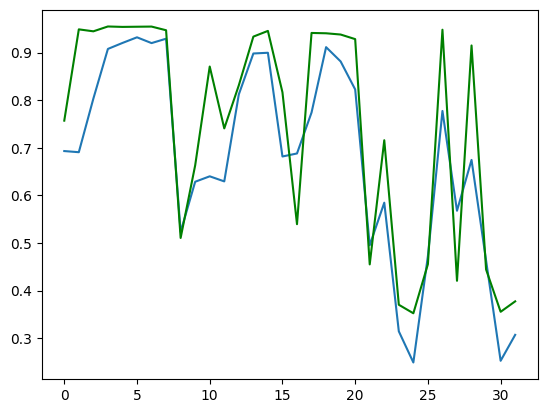

30
tensor([1.4105, 3.8700, 2.1520, 1.4267, 1.7480, 1.9244, 1.7767, 1.7612, 1.6952,
        1.2648, 1.9836, 1.1563, 1.6742, 1.5907, 1.3995, 1.8679, 1.7128, 2.4985,
        1.9252, 1.3551, 1.1506, 1.1548, 0.8534, 0.8954, 0.5938, 0.4216, 1.0106,
        0.5492, 0.5313, 0.7441, 0.4079, 0.5530, 0.6192, 0.4430, 0.6758, 0.8388,
        0.7444, 0.6039, 0.8481, 0.5553, 0.6480, 0.5310, 0.5076, 0.6525, 0.6819])


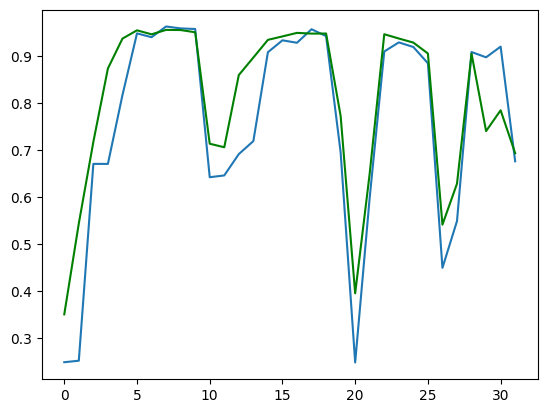

39
tensor([1.5482, 1.9828, 1.7587, 1.6290, 1.7381, 2.9200, 1.7059, 1.5316, 1.4426,
        1.3059, 1.5071, 1.2387, 1.5122, 1.2772, 1.3863, 1.2286, 1.3704, 1.9445,
        1.2201, 1.2872, 1.5464, 1.0090, 1.0311, 0.5489, 0.5802, 0.6894, 0.9051,
        0.6807, 0.7886, 0.6882, 0.4961, 0.6160, 0.4440, 0.4508, 0.3797, 0.6622,
        0.3809, 0.4441, 0.5424, 0.3135, 0.3794, 0.3291, 0.4142, 0.4073, 0.4621])


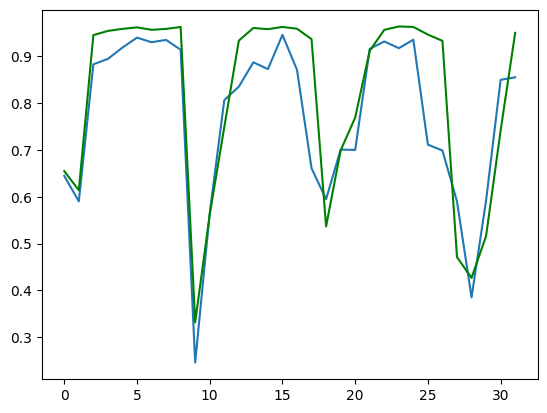

33
tensor([1.1502, 1.3982, 1.1569, 1.1187, 1.0338, 1.5761, 1.2718, 1.0884, 1.3005,
        1.2170, 1.0276, 1.3245, 1.1863, 1.1983, 1.0263, 1.0719, 0.9866, 1.1447,
        0.8329, 1.0807, 0.8632, 0.8107, 0.6908, 0.5521, 0.5669, 0.6870, 0.6277,
        0.4261, 0.4116, 0.5298, 0.3215, 0.4169, 0.3867, 0.2950, 0.4159, 0.5271,
        0.4385, 0.3033, 0.3349, 0.3774, 0.3703, 0.4112, 1.0723, 0.4508, 0.5308])


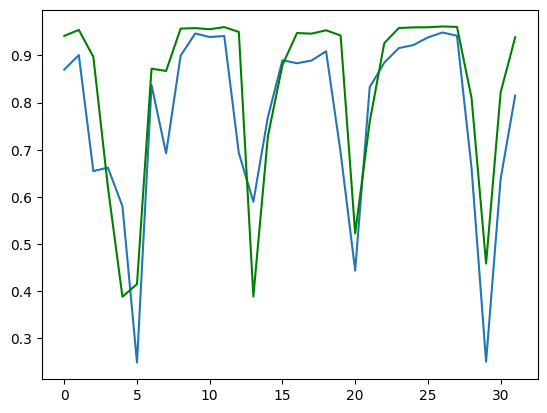

40
tensor([1.5977, 1.0704, 1.4340, 1.5024, 0.9768, 2.0427, 1.3877, 1.5076, 1.5511,
        1.4020, 1.2794, 0.9613, 1.2873, 1.1391, 0.8356, 1.2814, 1.1343, 1.3427,
        1.3107, 1.5541, 1.1957, 1.4762, 0.9323, 0.8811, 0.7247, 0.7504, 0.5837,
        0.5248, 0.5900, 0.6069, 0.5258, 0.5349, 0.5936, 0.5265, 0.5880, 0.5580,
        0.5483, 0.6401, 0.5047, 0.6223, 0.4792, 0.5544, 0.8714, 0.6145, 0.6550])


In [213]:
for i, m in enumerate(test_metrics):
    # plt.figure(figsize=(10, 5))
    plt.plot(m['target'], label='target')
    # plt.plot(m['pred'], label='pred', alpha=0.2, c='r')
    min_idx = ((m['target'].unsqueeze(1) - m['pred'])**2).sum(0).argmin()
    plt.plot(m['pred'][:, min_idx], c='g')
    plt.show()
    print(f'{min_idx}')
    print(((m['target'].unsqueeze(1) - m['pred'])**2).sum(0))

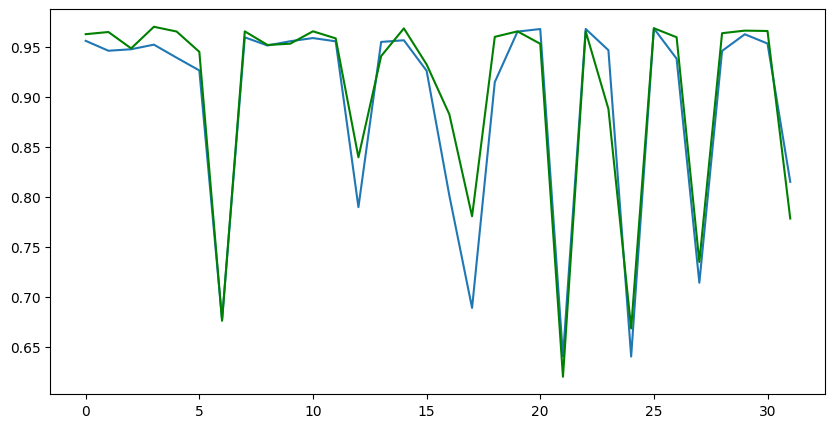

32
tensor([0.2810, 0.1823, 0.2682, 0.2620, 0.1492, 0.2484, 0.1869, 0.1405, 0.1447,
        0.1844, 0.1916, 0.1681, 0.1179, 0.1538, 0.1209, 0.1706, 0.1415, 0.1154,
        0.0771, 0.1488, 0.2069, 0.1875, 0.2012, 0.1767, 0.1724, 0.2798, 0.2003,
        0.2026, 0.0985, 0.2071, 0.1005, 0.1230, 0.0293, 0.0577, 0.0632, 0.0473,
        0.0386, 0.0582, 0.0645, 0.0839, 0.0435, 0.0677, 0.1784, 0.2018, 0.3616])


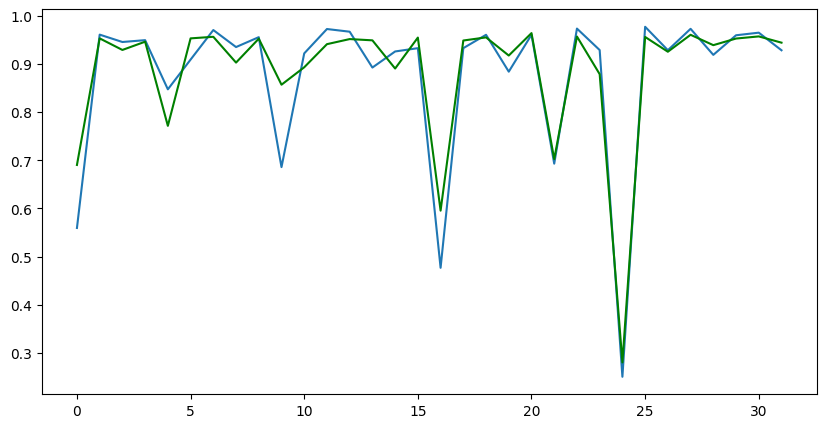

30
tensor([0.7095, 0.4182, 0.5517, 0.2966, 0.3019, 0.3766, 0.3281, 0.4235, 0.2940,
        0.2440, 0.2074, 0.1501, 0.1762, 0.4009, 0.2423, 0.3040, 0.4208, 0.2473,
        0.2441, 0.2061, 0.1260, 0.2059, 0.2353, 0.3921, 0.3079, 0.2912, 0.1253,
        0.2094, 0.1160, 0.1877, 0.0835, 0.1144, 0.1057, 0.1630, 0.1247, 0.1559,
        0.1446, 0.1620, 0.1499, 0.1728, 0.2015, 0.1315, 0.3552, 0.2376, 0.2936])


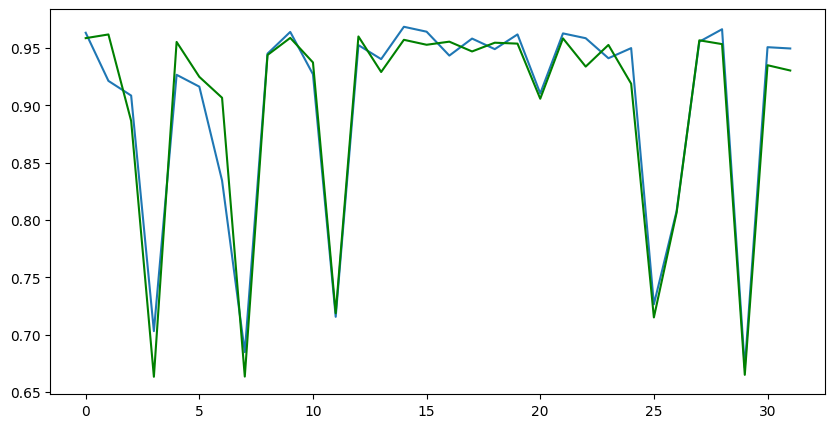

36
tensor([0.2271, 0.1907, 0.1682, 0.2084, 0.2129, 0.2326, 0.1986, 0.2327, 0.2218,
        0.1691, 0.2959, 0.1778, 0.2398, 0.2740, 0.1952, 0.3032, 0.4162, 0.2143,
        0.2387, 0.1972, 0.1359, 0.2527, 0.1083, 0.1692, 0.0877, 0.0792, 0.0694,
        0.1020, 0.1225, 0.1649, 0.0662, 0.0928, 0.0366, 0.0319, 0.0179, 0.0251,
        0.0140, 0.0328, 0.0268, 0.0203, 0.0209, 0.0148, 0.1280, 0.0927, 0.1189])


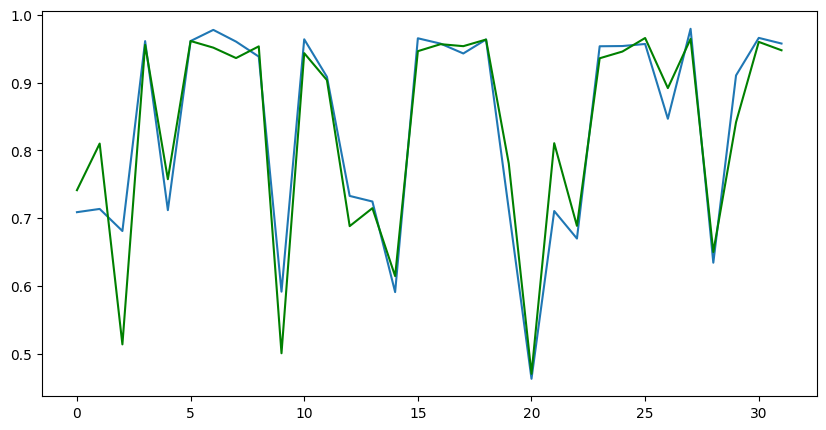

41
tensor([0.3542, 0.2777, 0.3572, 0.2966, 0.4393, 0.3938, 0.2593, 0.2489, 0.2918,
        0.2546, 0.2476, 0.1798, 0.2559, 0.2125, 0.1578, 0.2156, 0.2015, 0.3007,
        0.2086, 0.2027, 0.2199, 0.2561, 0.2961, 0.3061, 0.3163, 0.3404, 0.1849,
        0.2765, 0.1524, 0.2205, 0.2360, 0.3112, 0.2116, 0.1696, 0.1090, 0.1324,
        0.1559, 0.1281, 0.0949, 0.0931, 0.2168, 0.0766, 0.0989, 0.1917, 0.2643])


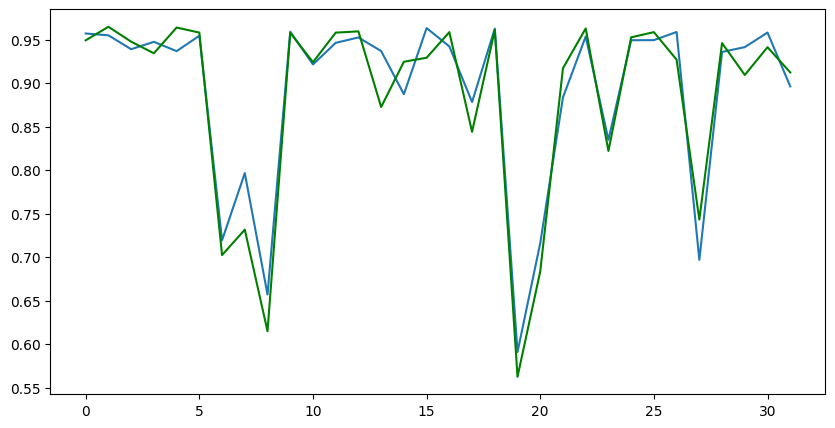

40
tensor([0.3589, 0.3672, 0.3450, 0.3622, 0.3356, 0.4364, 0.2809, 0.2378, 0.2596,
        0.3313, 0.2647, 0.3485, 0.3637, 0.3797, 0.2741, 0.2140, 0.4027, 0.1770,
        0.2870, 0.1035, 0.2447, 0.1282, 0.1445, 0.1850, 0.1648, 0.1417, 0.4203,
        0.2109, 0.1811, 0.1496, 0.2059, 0.2193, 0.0876, 0.0691, 0.0401, 0.0503,
        0.0396, 0.1182, 0.0776, 0.0283, 0.0239, 0.0493, 0.0947, 0.0995, 0.1529])


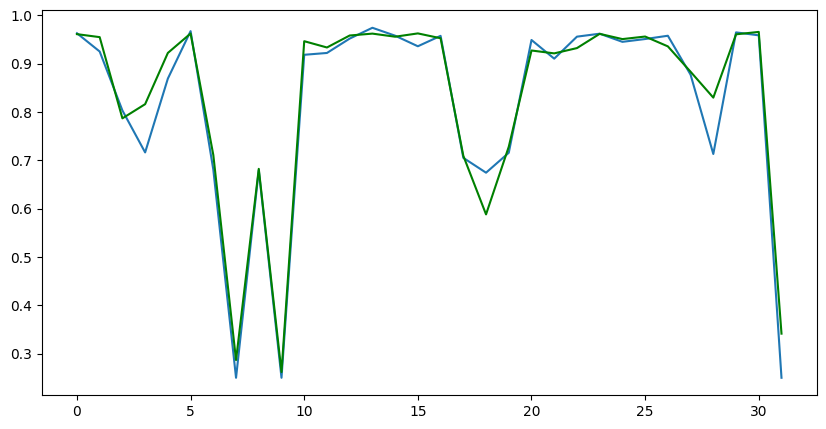

39
tensor([1.1741, 0.7052, 0.8453, 0.6448, 0.6330, 0.9205, 1.0120, 0.6834, 0.6225,
        0.6675, 0.6309, 0.5618, 0.5468, 0.6545, 0.4234, 0.6489, 0.6093, 0.5428,
        0.3354, 0.2639, 0.1676, 0.2875, 0.2604, 0.1708, 0.1757, 0.1174, 0.1439,
        0.1791, 0.1304, 0.1195, 0.0780, 0.0735, 0.0602, 0.0950, 0.0829, 0.0600,
        0.0695, 0.1363, 0.0982, 0.0496, 0.0682, 0.0573, 0.1984, 0.2053, 0.1942])


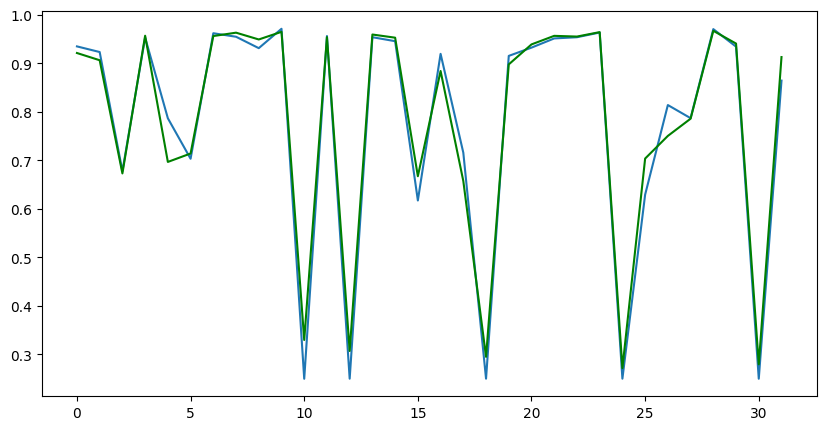

41
tensor([0.5930, 0.4382, 0.5269, 0.5497, 0.8800, 0.5829, 0.6709, 0.5253, 0.6329,
        0.7299, 0.5587, 0.6531, 0.6099, 0.7284, 0.7209, 0.2369, 0.5278, 0.3675,
        0.3604, 0.4320, 0.2957, 0.2948, 0.3918, 0.2770, 0.2654, 0.2178, 0.1437,
        0.2465, 0.1634, 0.1982, 0.1300, 0.1623, 0.0774, 0.0447, 0.0536, 0.0710,
        0.0597, 0.1492, 0.0576, 0.0594, 0.1271, 0.0418, 0.4613, 0.2536, 0.1545])


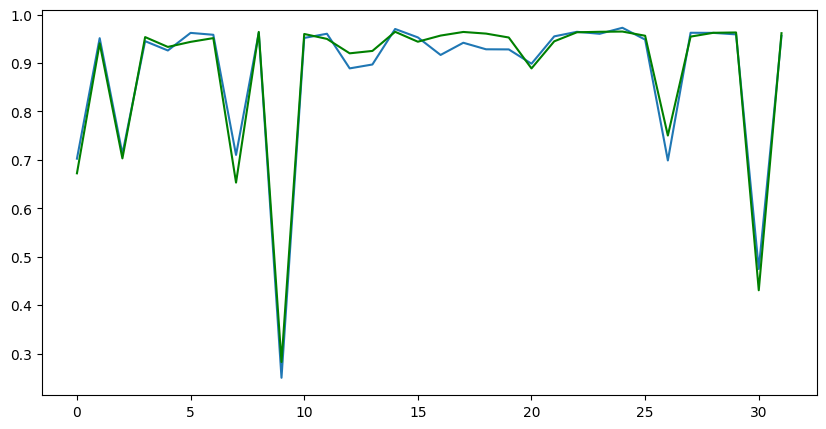

36
tensor([0.2773, 0.2445, 0.2590, 0.2829, 0.3210, 0.3745, 0.3181, 0.2841, 0.1491,
        0.1975, 0.1418, 0.3646, 0.3011, 0.2691, 0.2166, 0.1548, 0.1940, 0.1105,
        0.1772, 0.0471, 0.0687, 0.1541, 0.0372, 0.0596, 0.1064, 0.0395, 0.0547,
        0.0497, 0.0908, 0.0646, 0.0333, 0.0220, 0.0206, 0.1765, 0.0275, 0.0274,
        0.0168, 0.0475, 0.0320, 0.0222, 0.0880, 0.0267, 0.0794, 0.0496, 0.0765])


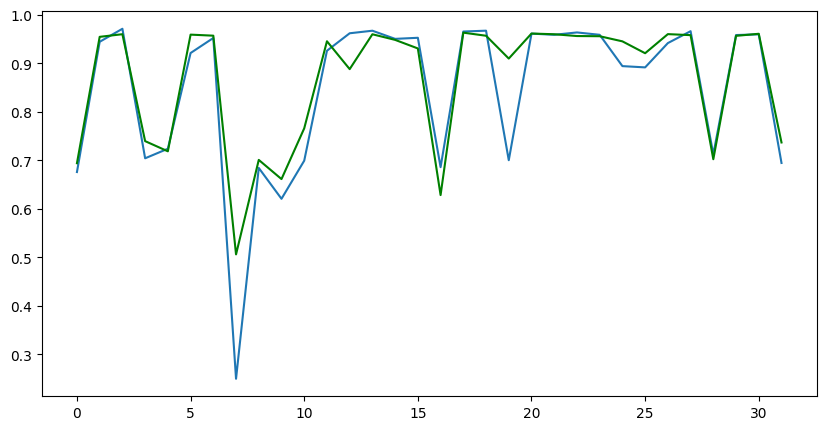

40
tensor([0.6984, 0.3820, 0.3202, 0.6387, 0.7918, 0.5688, 0.3099, 0.3285, 0.3383,
        0.6023, 0.4952, 0.5010, 0.5035, 0.5962, 0.6313, 0.7097, 0.4463, 0.6262,
        0.6013, 0.4676, 0.7006, 0.4470, 0.3781, 0.5601, 0.5721, 0.4877, 0.7089,
        0.5748, 0.6292, 0.5989, 0.3170, 0.3476, 0.3430, 0.2437, 0.2463, 0.2700,
        0.2578, 0.2391, 0.1596, 0.1860, 0.1347, 0.3450, 0.5247, 0.5541, 0.3590])


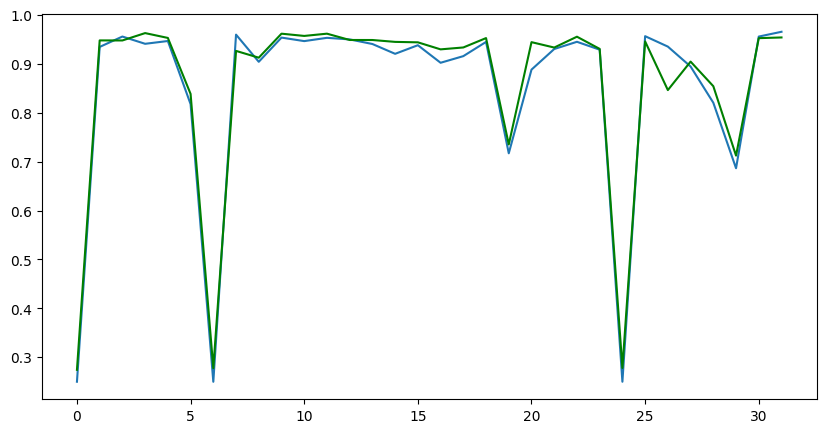

40
tensor([0.7991, 0.3334, 0.4969, 0.4207, 0.2938, 0.8392, 0.6231, 0.5502, 0.3918,
        0.3071, 0.2356, 0.2458, 0.4246, 0.4766, 0.4434, 0.4159, 0.4343, 0.4231,
        0.1753, 0.2024, 0.1628, 0.2203, 0.2394, 0.2420, 0.2211, 0.1171, 0.1822,
        0.1792, 0.1385, 0.1303, 0.1398, 0.1003, 0.1249, 0.0928, 0.1143, 0.0340,
        0.0551, 0.0605, 0.0516, 0.0291, 0.0203, 0.0347, 0.1531, 0.1235, 0.1336])


In [200]:
for i, m in enumerate(metrics):
    if i%100 != 0:
        continue
    plt.figure(figsize=(10, 5))
    plt.plot(m['target'], label='target')
    # plt.plot(m['pred'], label='pred', alpha=0.2, c='r')
    min_idx = ((m['target'].unsqueeze(1) - m['pred'])**2).sum(0).argmin()
    plt.plot(m['pred'][:, min_idx], c='g')
    plt.show()
    print(f'{min_idx}')
    print(((m['target'].unsqueeze(1) - m['pred'])**2).sum(0))

In [195]:
((m['target'].unsqueeze(1) - m['pred'])**2).sum(0).argmin()

tensor(40)

In [55]:
for input_size in [
    [32, 64, 32, 32],
    [32, 32, 64, 64],
    [32, 16, 128, 128],
    [32, 8, 256, 256]
]:
    
    model = ScorePredictor(
        input_size=input_size,
        output_dim=4,
        hidden_dim=8,
        dropout_prob=0.3
    )

    print(count_parameters(model))

    input = torch.randn(input_size)
    output = model(input)

66132
131272
262242
524359


In [47]:
# count parameters of test variable
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

count_parameters(test)

66132

In [48]:
input = torch.randn(32, 64, 32, 32)
output = test(input)

In [51]:
list(input.shape)

[32, 64, 32, 32]

In [50]:
output.shape

torch.Size([32, 4])